### Check code

This notebook is to check the code generated from [First_experiment]Infection_Benchmark.ipynb works as expected after moved to attention_analysis_utils.py and visualization_utils.py.

#### Test with the Karate Club dataset

In [1]:
import matplotlib.pyplot as plt
import torch
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from models import GAT_L2, GAT_L3
from typing import Dict

# Define the dataset
data = KarateClub()[0]
# Initialize the model
num_classes = data.y.max().item() + 1
model = GAT_L2(in_channels=data.num_features, 
               hidden_channels=8, 
               out_channels=num_classes,
               heads=1,)
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
model = model.to(device)
# Move the data to the device
data = data.to(device)
# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [7]:
# Import the utility functions
from attention_analysis_utils import (
    k_hop_subgraph_modified, 
    get_computation_graph_local,
    get_attention_weights_karate,
    get_attention_weights_dict_all,
)
from torch_geometric.utils import get_num_hops
from visualization_utils import vis_comp_graph 

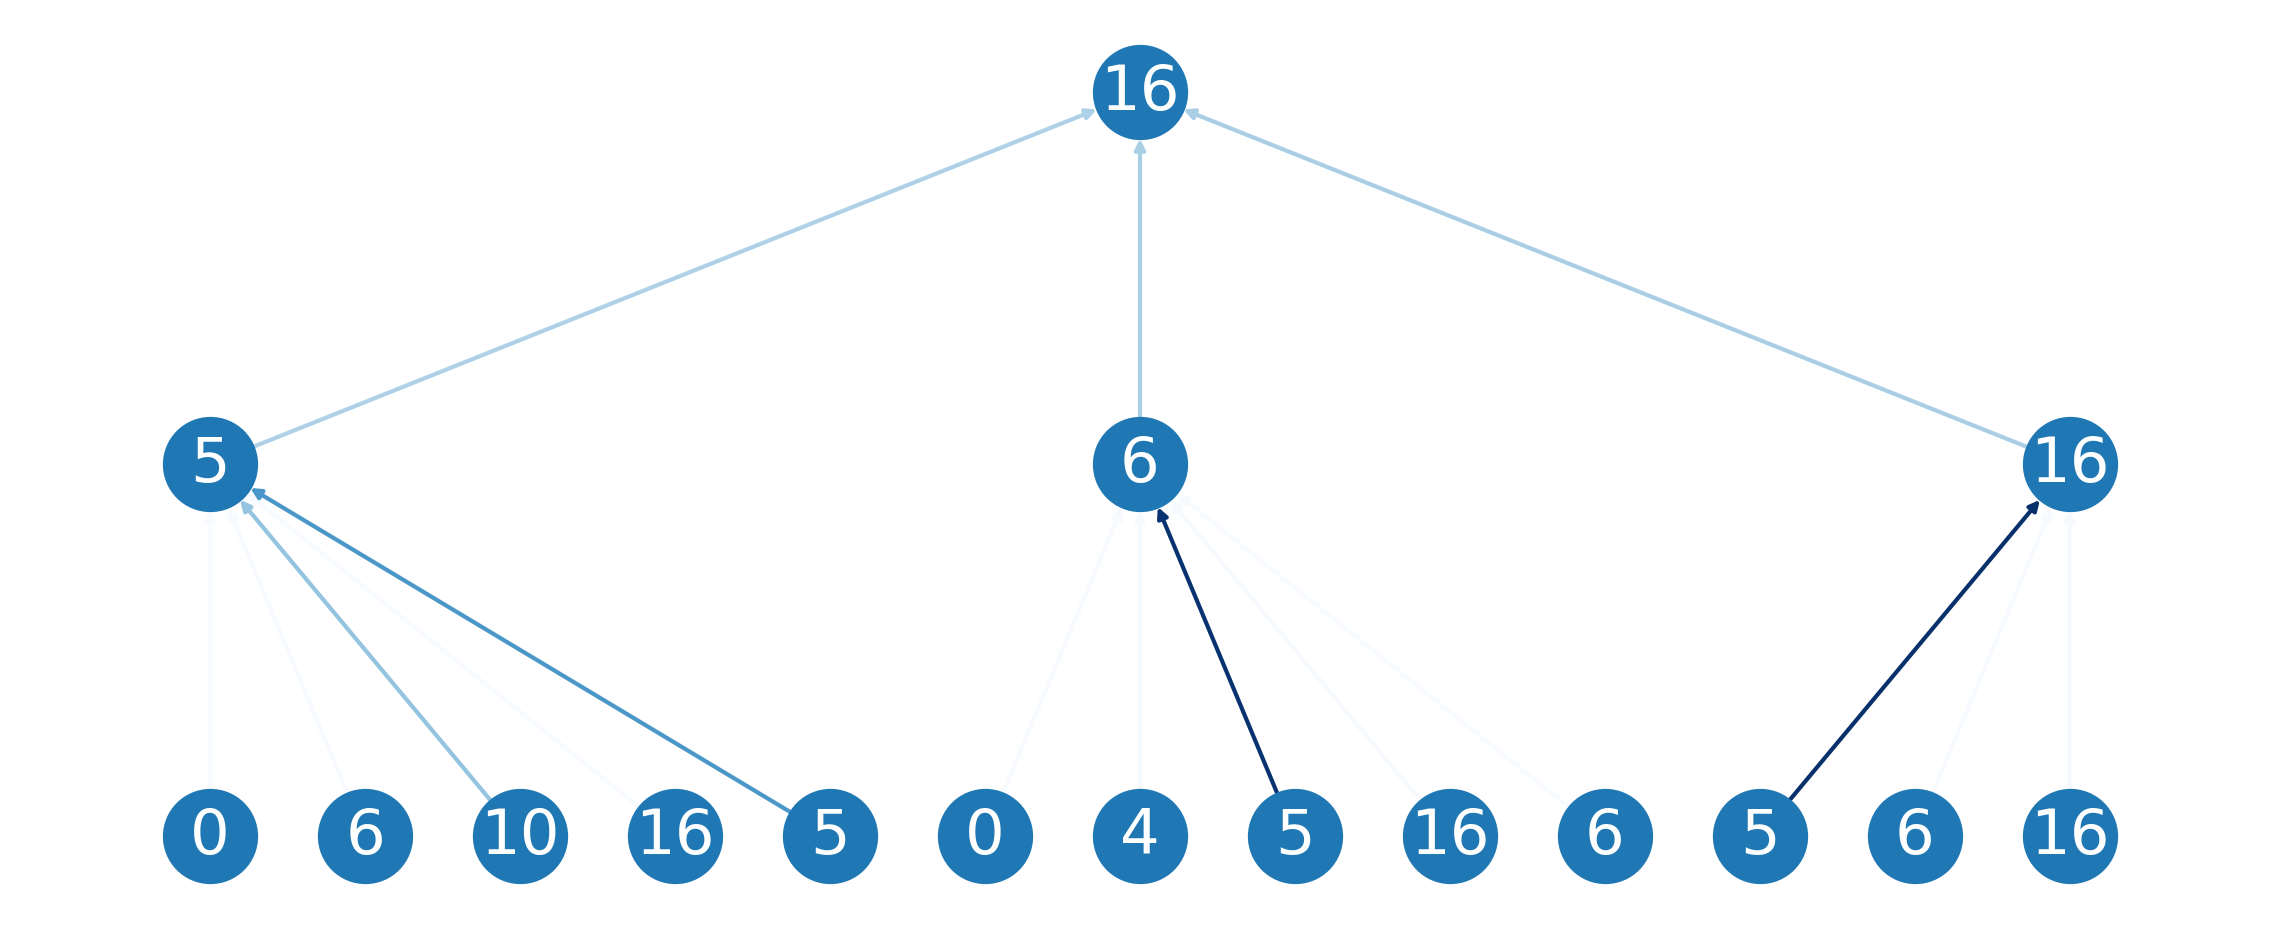

In [4]:
target_node = 16
num_layers = 2

subset, local_edge_index, inv, edge_mask, new_levels = k_hop_subgraph_modified(
    node_idx=target_node, num_hops=num_layers, edge_index=data.edge_index
)
comp_graph = get_computation_graph_local(
    edge_index=local_edge_index, k=num_layers, shifted_target_idx=inv[0]
)
att_tuple = get_attention_weights_karate(
    k_hop_edge_index=local_edge_index, subset=subset, model=model, data=data
)
att_edge_dict = get_attention_weights_dict_all(att_tuple=att_tuple)
vis_comp_graph(comp_graph=comp_graph, att_tuple=att_tuple, subset=subset)

#### Test with the infection dataset

In [17]:
# Import the utility functions
from attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer
)

from torch_geometric.utils import get_num_hops
from visualization_utils import (
    visualize_computation_graph,
    draw_local_comp_graph_with_ground_truth_path,
)

In [15]:
device = torch.device("cpu")
# Load the network data locally (for reproduction)
data = torch.load("/workspace/Infection_dataset_small.pt").to(device)
# Load model as a whole
model = torch.load("/workspace/GAT_infection_small.pt").to(device)
model.eval()

GAT_L2(
  (conv1): GATConv(2, 8, heads=1)
  (conv2): GATConv(8, 5, heads=1)
)

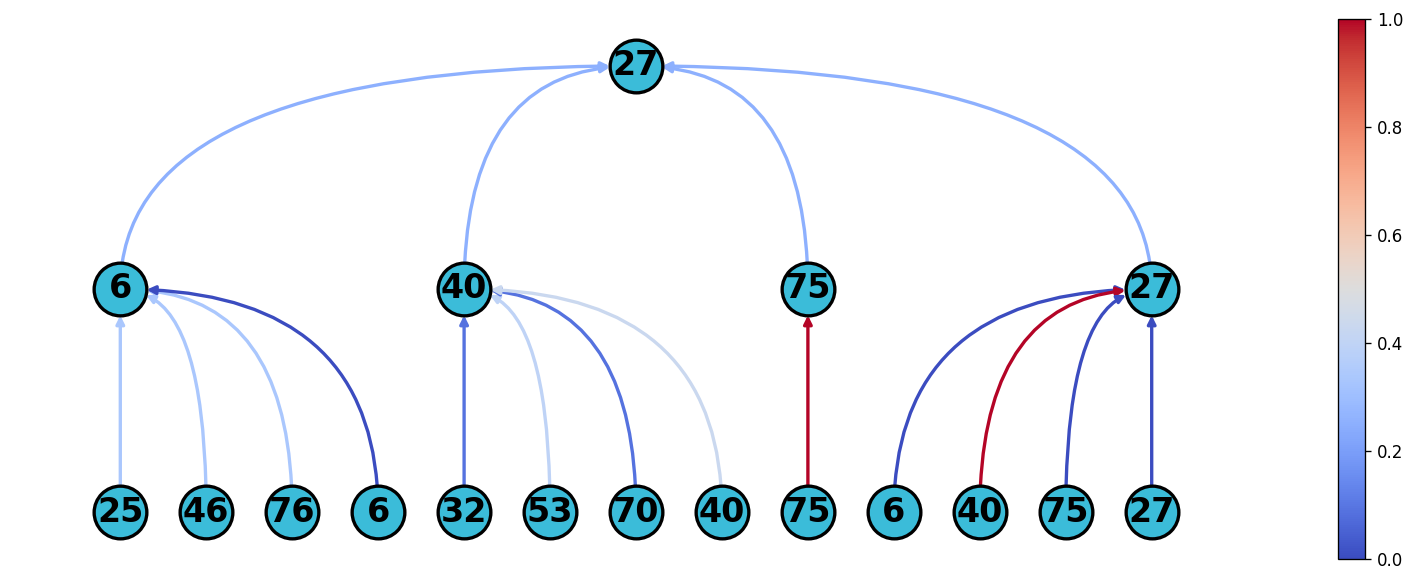

In [16]:
target_idx = 27
num_layers = get_num_hops(model)

att_dict_raw = get_attention_raw_dict(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_idx
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
)
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
)

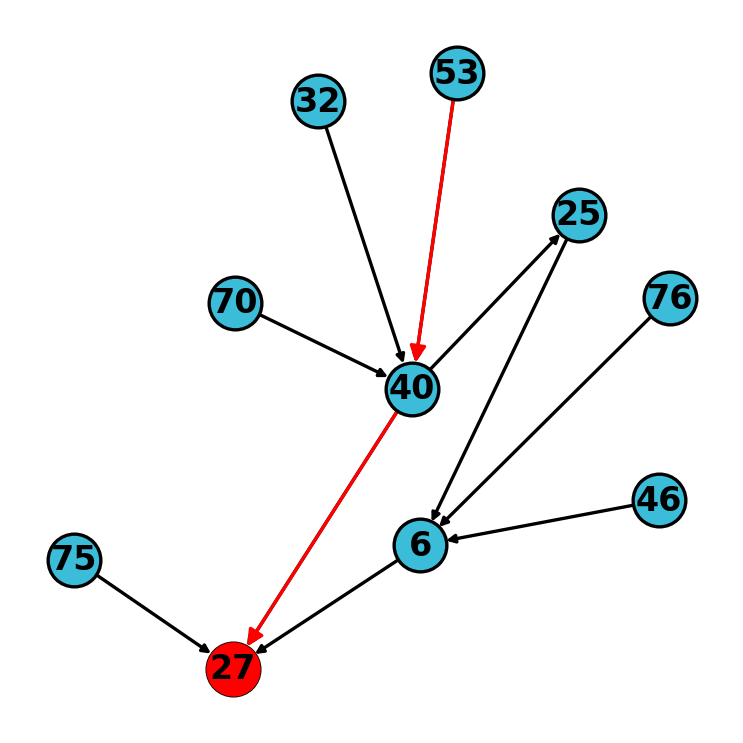

In [18]:
draw_local_comp_graph_with_ground_truth_path(data=data,
                                            hops=num_layers,
                                            target_idx=target_idx,)

In [19]:
layer_att_dict

{0: {(1, 0): 0.25, (2, 0): 0.25, (3, 0): 0.25, (4, 0): 0.25},
 1: {(5, 1): 0.33303219079971313,
  (6, 1): 0.3333473801612854,
  (7, 1): 0.33350512385368347,
  (8, 1): 0.00011528600589372218,
  (9, 2): 0.08734562993049622,
  (10, 2): 0.39531180262565613,
  (11, 2): 0.08734562993049622,
  (12, 2): 0.42999687790870667,
  (13, 3): 1.0,
  (14, 4): 0.0003454849938862026,
  (15, 4): 0.9989635944366455,
  (16, 4): 0.0003454849938862026,
  (17, 4): 0.0003454849938862026}}

#### Test with the larger infection dataset

In [1]:
# Import the utility functions
from visualization_utils import visualizer_automatic
import torch

In [4]:
device = torch.device("cpu")
# First, load the dataset from local
data = torch.load("/workspace/Infection_50003d.pt").to(device)
# Also import the model
model = torch.load("/workspace/GAT_infection_3L1H.pt").to(device)

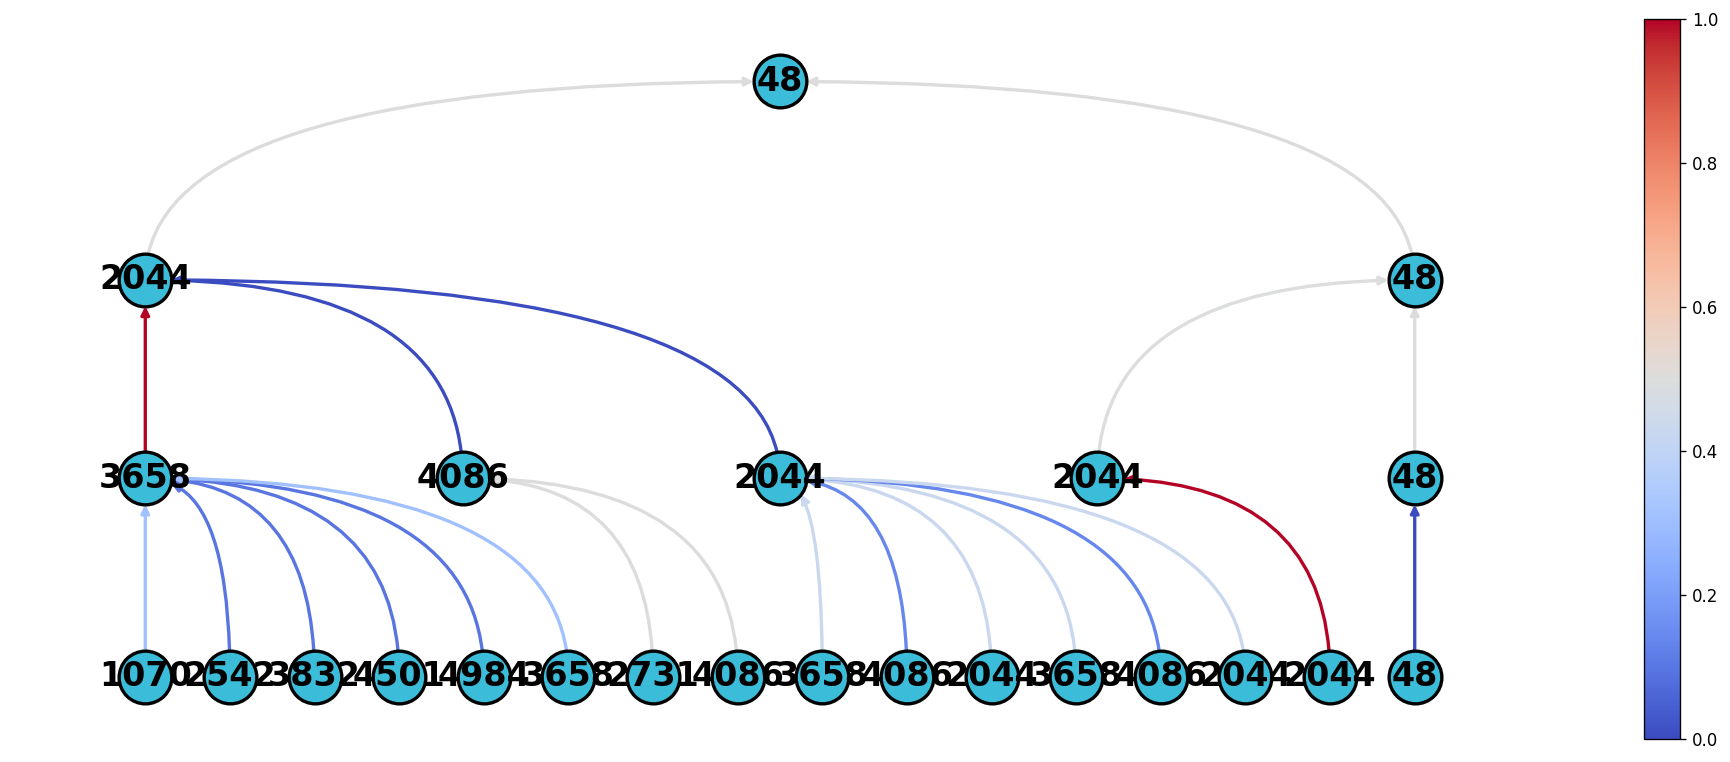

In [6]:
target_idx = 48
visualizer_automatic(data=data, model=model, num_layers=3, target_idx=target_idx)